In [4]:
# Online training of a logistic regression model
# using Assumed Density Filtering (ADF).
# We compare the ADF result with MCMC sampling
# For further details, see the ADF paper:
#   * O. Zoeter, "Bayesian Generalized Linear Models in a Terabyte World,"
#     2007 5th International Symposium on Image and Signal Processing and Analysis, 2007,
#     pp. 435-440, doi: 10.1109/ISPA.2007.4383733.
# of the posterior distribution

# Author: Gerardo Durán-Martín (@gerdm)


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax import random
from jax.scipy.stats import norm

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml


try:
    from jsl.demos import logreg_biclusters as demo
except ModuleNotFoundError:
    %pip install -qq jsl
    from jsl.demos import logreg_biclusters as demo

import probml_utils as pml

MCMC weights
[-0.08053391  1.4072946   0.6854921 ]

Laplace weights
[-0.01893959  1.2842249   0.6131875 ]



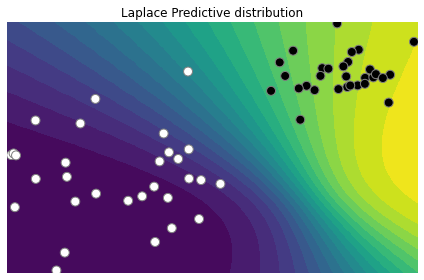

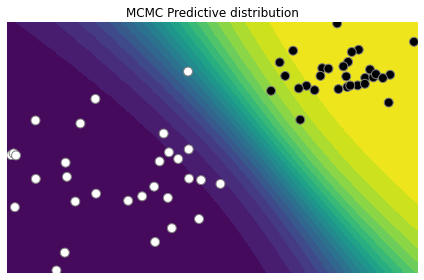

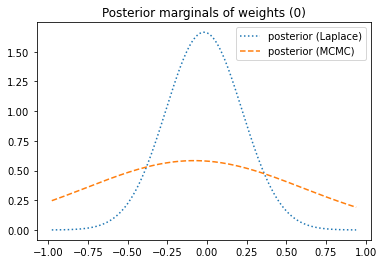

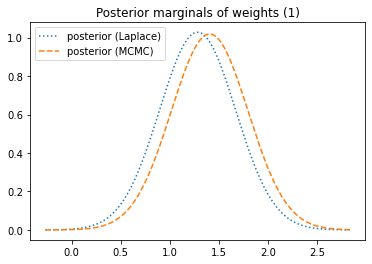

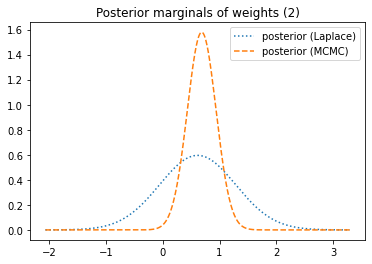

In [3]:
figures, data = demo.main()

X = data["X"]
y = data["y"]
Phi = data["Phi"]
Xspace = data["Xspace"]
Phispace = data["Phispace"]
w_laplace = data["w_laplace"]

$$
    \eta_t = \sigma({\bf w}_t^T {\bf x}_t) + q_t; q_t \sim \mathcal{N}(0, v_t)
$$

$$
    p({\bf w}_t \vert {\bf w}_{t-1}) = \prod_j\mathcal{N}(w_t^j \vert  \mu_{t \vert t-1}, \tau_{t \vert t-1}^j)
$$

In [5]:
def h(n, a, b): return (b - a) / 2 ** n

def romb_row_init(R_prev: float, n: int, a: int, b: int, f):
    """
    Parameters
    R_prev: float
        R(n-1, 0) value
    n: int
    a: int
    b: int
    """
    k_points = jnp.arange(1, 2 ** (n - 1) + 1)
    eval_points = a + (2 * k_points - 1) * h(n, a, b)
    R_init = R_prev / 2 + h(n, a, b) * f(eval_points).sum()
    
    return R_init


def romb(f, a, b, n_iterations=4):
    """
    O(x^2) implementation of Romberg's method.
    Reference: https://en.wikipedia.org/wiki/Romberg%27s_method
    """
    R_values = jnp.zeros((n_iterations + 1, n_iterations + 1))

    R = h(1, a, b) * (f(a) + f(b))
    R_values = R_values.at[0, 0].set(R)

    for n in range(1, n_iterations + 1):
        R = romb_row_init(R_values[n - 1, 0], n, a, b, f)
        R_values = R_values.at[n, 0].set(R)

        for m in range(1, n + 1):
            R = (4 ** m * R_values[n, m - 1] - R_values[n - 1, m - 1]) / (4 ** m - 1)
            R_values = R_values.at[n, m].set(R)
    I = R_values[-1, -1]
    return I

In [ ]:
def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log1p(jnp.exp(z))


def Zt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return jnp.exp(log_term)


def mt_func(eta, y, mu, v, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta * jnp.exp(log_term) / Zt


def vt_func(eta, y, mu, v, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta**2 * jnp.exp(log_term) / Zt


def adf_step(state, xs, prior_variance, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs

    mu_t_cond = mu_t
    tau_t_cond = tau_t + prior_variance

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    # Moment-matched Gaussian approximation elements
    Zt = romb(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), lbound, ubound)

    mt = romb(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)

    vt = romb(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    vt = vt - mt ** 2
    
    # Posterior estimation
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond
    a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()
    
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a**2 * delta_v

    return (mu_t, tau_t), (mu_t, tau_t)

In [15]:
def sample_posterior_predictive2d(key, domain, mean, cov, n_samples=5000):
    samples = jax.random.multivariate_normal(key, mean, cov, (n_samples,))
    Z = sigmoid(jnp.einsum("mij,sm->sij", domain, samples))
    Z = Z.mean(axis=0)
    return Z

def plot_adf_post_laplace(mu_hist, tau_hist, w_fix, lcolors, label):
    elements = (mu_hist.T, tau_hist.T, w_fix, lcolors)
    n_datapoints = len(mu_hist)
    timesteps = jnp.arange(n_datapoints) + 1
    
    for k, (wk, Pk, wk_fix, c) in enumerate(zip(*elements)):
        fig_weight_k, ax = plt.subplots()
        ax.errorbar(timesteps, wk, jnp.sqrt(Pk), c=c, label=f"$w_{k}$ online (adf)")
        ax.axhline(y=wk_fix, c=c, linestyle="dotted", label=f"$w_{k}$ batch (Laplace)", linewidth=3)

        ax.set_xlim(1, n_datapoints)
        ax.legend(framealpha=0.7, loc="upper right")
        ax.set_xlabel("number samples")
        ax.set_ylabel("weights")
        plt.tight_layout()
        pml.savefig(label.format(k=k))

In [16]:
key = random.PRNGKey(3141)
key_pp, key_shuffle = jax.random.split(key)

ADF weights
[-0.13611867  1.2175896   0.71540636]


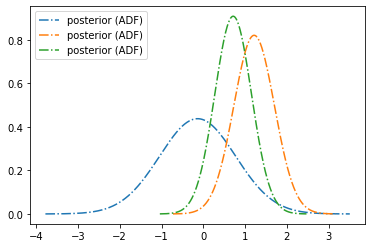

In [17]:
# ** ADF inference **
prior_variance = 0.00

n_datapoints, ndims = Phi.shape
lbound, ubound = -12, 12
mu_0 = jnp.zeros(ndims) * 0.0
tau_0 = jnp.ones(ndims) * 1.0

init_state = (mu_0, tau_0)
xs = (Phi, y)
colors = ["black" if el else "red" for el in y]

adf_loop = partial(adf_step, prior_variance=prior_variance, lbound=lbound, ubound=ubound)
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)
print("ADF weights")
print(mu_t)

# ADF posterior predictive distribution
Z_adf = sample_posterior_predictive2d(key_pp, Phispace, mu_t, jnp.diag(tau_t))

# ** Plotting predictive distribution **
fig, ax = plt.subplots()
for i in range(ndims):
    mean, std = mu_t[i], jnp.sqrt(tau_t[i])
    ax = fig.gca()
    x = jnp.linspace(mean - 4 * std, mean + 4 * std, 500)
    ax.plot(x, norm.pdf(x, mean, std), label="posterior (ADF)", linestyle="dashdot")
    ax.legend()

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


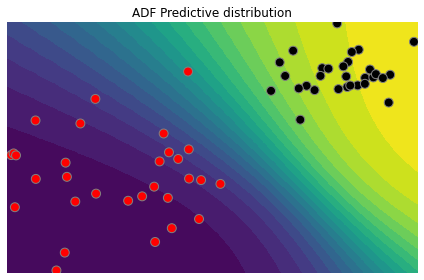

In [18]:
fig_adf, ax = plt.subplots()
title = "ADF Predictive distribution"
demo.plot_posterior_predictive(ax, X, Xspace, Z_adf, title, colors, cmap="viridis")
pml.savefig("logistic_regression_surface_adf.pdf")

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


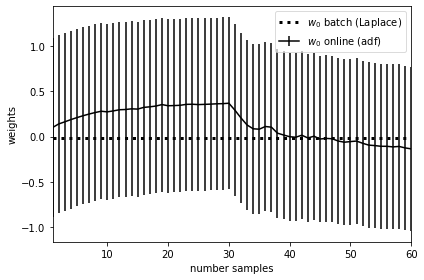

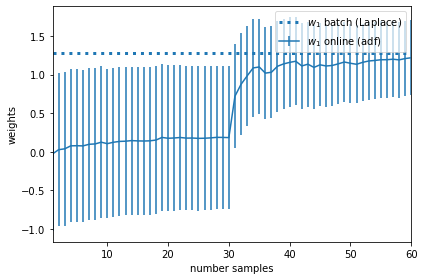

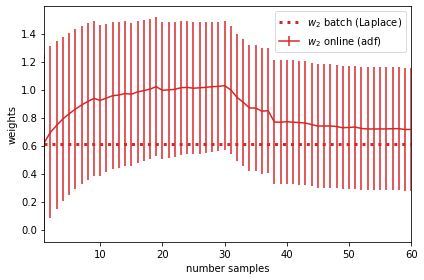

In [21]:
lcolors = ["black", "tab:blue", "tab:red"]
label = "logistic_regression_hist_adf_w{k}"
plot_adf_post_laplace(mu_t_hist, tau_t_hist, w_laplace, lcolors, label)

# Shuffling dataset

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


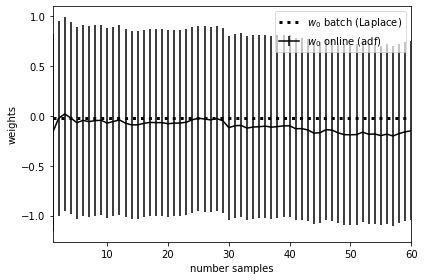

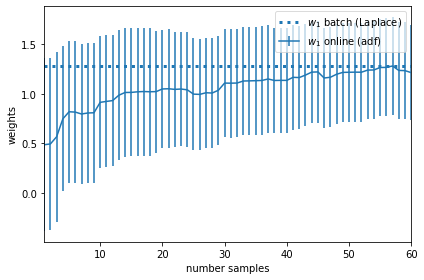

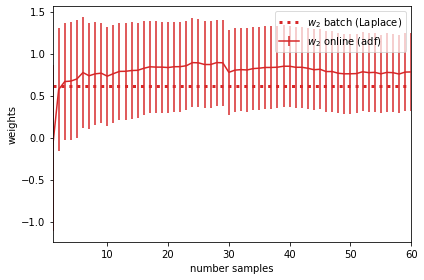

In [23]:
init_state = (mu_0, tau_0)
D = jnp.c_[Phi, y]
D = jax.random.permutation(key_shuffle, D, axis=0, independent=False)
Phi_shuff, y_shuff = D[:, :-1], D[:, -1]
xs = (Phi_shuff, y_shuff)
colors = ["black" if el else "red" for el in y]

adf_loop = partial(adf_step, prior_variance=prior_variance, lbound=lbound, ubound=ubound)
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)

label = "logistic_regression_hist_adf_shuffled_w{k}"
plot_adf_post_laplace(mu_t_hist, tau_t_hist, w_laplace, lcolors, label)